# Collect data from IEDB

首先在 [IEDB](https://www.iedb.org/) 上搜索相关数据，然后导出，放在 ``TCRdata/raw/database/IEDB/`` 文件夹下。示例：
- receptor_table_export_1694687913.csv
  - downloaded from IEDB on 2023.9.14
  - filters: Linear Peptide, T cell(positive), Human
  - csv format: 2 header

In [1]:
import os
import pandas as pd
from utils import save_csv, plot_non_empty_percentage

to_your_path = '/data/lujd/'

### ¶ prepare data

In [4]:
''' 
Instructions:
    receptor_table_export_1694687913.csv: downloaded from IEDB on 2023.9.14
    filters: Linear Peptide, T cell(positive), Human
    csv format: 2 header
    no. unique samples: 207439

    receptor_table_export_1716350323.csv: downloaded from IEDB on 2024.5.22
    filters: Linear Peptide, T cell(positive), Human
    csv format: 2 header
    no. unique samples: 208792
'''

datapath = to_your_path + "TCRdata/raw/database/IEDB/receptor_table_export_1716350323.csv"
iedb_df = pd.read_csv(datapath, sep=",", header=1, low_memory=False)
iedb_df.drop_duplicates(inplace=True, ignore_index=True)

print(f"number of rows: {len(iedb_df)}")

number of rows: 208792


In [5]:
# remove 'gammadelta' or nan TCR Type
iedb_df_ab = iedb_df[iedb_df['Type']=='alphabeta']
print(f"number of rows: {len(iedb_df_ab)}")

number of rows: 208780


### ¶ Keep main information

In [6]:
# clear data
# format: (detailed information that we need) | (references that may be helpful)
brief_iedb_df_ab = iedb_df_ab[
    [   'Name', 'MHC Allele Names', 'IEDB Receptor ID', 'Reference Name',                       # Peptide, MHC, TCR(ID, Name)
        'Calculated V Gene', 'Calculated D Gene', 'Calculated J Gene',
        'Protein Sequence', 'CDR1 Calculated', 'CDR2 Calculated', 'CDR3 Calculated',            # TCR alpha chain
        'Calculated V Gene.1', 'Calculated D Gene.1', 'Calculated J Gene.1',
        'Protein Sequence.1', 'CDR1 Calculated.1', 'CDR2 Calculated.1', 'CDR3 Calculated.1',    # TCR beta chain
        'Source Molecule', 'Source Organism',
        'Group IRI', 'IEDB IRI', 'IEDB IRI.1', 'Protein IRI', 'Protein IRI.1'                   # reference links
        ]]
brief_iedb_df_ab = brief_iedb_df_ab.rename(
                                        columns={
                                                'Name':'antigen.epitope',
                                                'MHC Allele Names':'mhc.allele',
                                                'IEDB Receptor ID':'tcr.id',
                                                'Reference Name':'tcr.name',
                                                'Calculated V Gene':'alpha.v', 
                                                'Calculated D Gene':'alpha.d', 
                                                'Calculated J Gene':'alpha.j', 
                                                'Protein Sequence':'alpha.seq', 
                                                'CDR1 Calculated':'alpha.cdr1',
                                                'CDR2 Calculated':'alpha.cdr2',
                                                'CDR3 Calculated':'alpha.cdr3',
                                                'Calculated V Gene.1':'beta.v', 
                                                'Calculated D Gene.1':'beta.d', 
                                                'Calculated J Gene.1':'beta.j', 
                                                'Protein Sequence.1':'beta.seq', 
                                                'CDR1 Calculated.1':'beta.cdr1',
                                                'CDR2 Calculated.1':'beta.cdr2',
                                                'CDR3 Calculated.1':'beta.cdr3',
                                                'Group IRI':'iedb.url',
                                                'IEDB IRI':'iedb.iri1',
                                                'IEDB IRI.1':'iedb.iri2',
                                                'Protein IRI':'alpha.iri',
                                                'Protein IRI.1':'beta.iri'})

# statistic
for col in brief_iedb_df_ab.columns:
    print(f"{col}'s number: {brief_iedb_df_ab[col].nunique()} ")

antigen.epitope's number: 2361 
mhc.allele's number: 182 
tcr.id's number: 196482 
tcr.name's number: 11041 
alpha.v's number: 119 
alpha.d's number: 0 
alpha.j's number: 117 
alpha.seq's number: 285 
alpha.cdr1's number: 57 
alpha.cdr2's number: 47 
alpha.cdr3's number: 205 
beta.v's number: 165 
beta.d's number: 5 
beta.j's number: 36 
beta.seq's number: 303 
beta.cdr1's number: 36 
beta.cdr2's number: 41 
beta.cdr3's number: 115210 
Source Molecule's number: 548 
Source Organism's number: 115 
iedb.url's number: 177438 
iedb.iri1's number: 402 
iedb.iri2's number: 2361 
alpha.iri's number: 205 
beta.iri's number: 229 


### ¶ Extract V domain sequences from Group IRI

- **``IEDB_vseq.csv`` is already in ``./logs/``**
- if from scratch:
    - save data to ``TCRdata/collect/`` first
    - use ``python fetch_url_faster.py >> ./logs/IEDB_vseq.csv`` to fetch vseqs from iedb.url(Group IRI)
    - check invalid urls in `IEDB_vseq.csv` using special tags: "Failed to fetch.." or "An error occurred..."
    - add head over the `IEDB_vseq.csv`: ``iedb.url,alpha.vseq,beta.vseq``
- merge vseq into *brief_iedb_df_ab*:

In [9]:
vseq_df = pd.read_csv("./logs/IEDB_vseq.csv", sep=",", index_col=0, header=0, low_memory=False)
iedburl2avseq_dict = vseq_df["alpha.vseq"].to_dict()
iedburl2bvseq_dict = vseq_df["beta.vseq"].to_dict()

# get v seqs from iedb.url
def get_vseq(data):
    return iedburl2avseq_dict.get(data), iedburl2bvseq_dict.get(data)

brief_iedb_df_ab[['alpha.vseq', 'beta.vseq']] = brief_iedb_df_ab['iedb.url'].apply(lambda x: pd.Series(get_vseq(x)))

### ¶ Save data to ``TCRdata/collect/``

In [10]:
print(f"number of brief data: {len(brief_iedb_df_ab)}")

final_iedb_df_ab = brief_iedb_df_ab.drop_duplicates(ignore_index=True)
print(f"number of duplicated brief data: {len(final_iedb_df_ab)}")

savepath = to_your_path + "TCRdata/collect/"
savename = "IEDB.csv"
save_csv(final_iedb_df_ab, savepath, savename)

number of brief data: 208780
number of duplicated brief data: 205670
File /data/lujd/TCRdata/collect/IEDB.csv has been successfully saved.


---
### ¶ Barplot to see how many elements are missing?

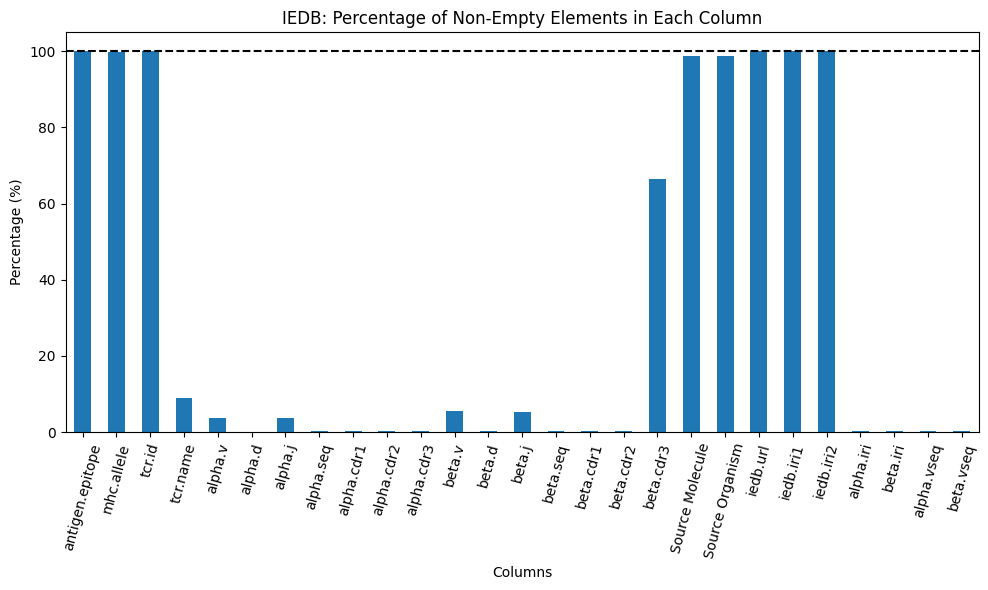

In [11]:
database = 'IEDB'
plot_non_empty_percentage(final_iedb_df_ab, database)